In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os
import sys
sys.path.append("..")

In [34]:
from model import YModel, OptLoss
from gan import Generator, Discriminator, WSDiscriminator, GANLosses
from metrics import Metrics
from utils import sample_noise, iterate_minibatches, generate_data

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)


In [35]:
from comet_ml import API
import comet_ml

%matplotlib inline

In [36]:
from collections import defaultdict

In [37]:
def extract_metrics(exp, hyper_params, metrics, mask):
    for metric in exp.data['metrics']:
        metric_values = np.array(list(zip(*exp.metrics_raw[metric]))[1])
        metrics[metric].append([metric_values[mask], hyper_params['data_size']])

In [6]:
#mask = list(np.arange(0, 20)) + [50] + [100]
mask = list(np.arange(500))

In [38]:
comet_api = API()
comet_api.get()

['shir994']

In [190]:
# plt.figure(figsize=(12,6))
# plt.pcolormesh(range(0,30), sizes, data, cmap=my_cmap);
# plt.colorbar()
# plt.yscale("log")

In [18]:
# metrics = list(zip(*exp.metrics_raw["train_average_mu_JS"]))
# plt.plot(*metrics);

# Check model

In [39]:
exp = comet_api.get("shir994/interpolation-test-1d/f68466fbf75e4566aafa339b7fe59803")
hyper_params = {}
for param in exp.parameters:
    hyper_params[param["name"]] = param["valueMin"]

In [40]:
TASK = int(hyper_params['TASK'])
NOISE_DIM = int(hyper_params["NOISE_DIM"])

In [41]:
generator = Generator(NOISE_DIM, out_dim = 1).to(device)
if TASK == 4:
    discriminator = WSDiscriminator(in_dim=1).to(device)
else:
    discriminator = Discriminator(in_dim=1).to(device)

y_sampler = YModel()
fixed_noise = torch.Tensor(sample_noise(10000, NOISE_DIM)).to(device)
metric_calc = Metrics((-50, 50), 100)

In [42]:
import io

asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == "interpolation_test_1d_interpol.tar"][0]
params = exp.get_asset(asset_id)
state_dict = torch.load(io.BytesIO(params))

In [43]:
state_dict.keys()

dict_keys(['gen_state_dict', 'dis_state_dict', 'genopt_state_dict', 'disopt_state_dict', 'epoch'])

In [44]:
generator.load_state_dict(state_dict['gen_state_dict'])

In [45]:
import io

asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == "train_inputs.npy"][0]
params = exp.get_asset(asset_id)
train_inputs = np.load(io.BytesIO(params))

In [58]:
mu_dim = 1
x_dim = 1

In [48]:
np.unique(train_inputs[:,0])

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
      dtype=float32)

In [56]:
def draw_mu_samples(mu, noise_size=1000, n_samples=1000):
    f = plt.figure(figsize=(21,16))
    #mu = dist.Uniform(*mu_range).sample([16, mu_dim])
    for index in range(16):
        plt.subplot(4, 4, index + 1)
        noise = torch.Tensor(sample_noise(fixed_noise.shape[0], fixed_noise.shape[1])).to(device)
        mu_s = mu[index, :].repeat(fixed_noise.shape[0], mu_dim).to(device)
        x_s = y_sampler.x_dist.sample([len(mu_s), x_dim]).to(device)
        y_sampler.make_condition_sample({'mu': mu_s, 'X':x_s})

        plt.hist(y_sampler.condition_sample().cpu().numpy(), bins=100, density=True, label='true');
        plt.hist(generator(noise, torch.cat([mu_s, x_s], dim=1)).detach().cpu().numpy(),
                 bins=100, color='g', density=True, alpha=0.5, label='gan');    
        plt.grid()
        plt.legend()
        plt.title("mu={}".format(mu[index, :].cpu().numpy()), fontsize=15);
    return f

In [63]:
mu = torch.linspace(5,10,16).reshape(-1,1)
mu.shape

torch.Size([16, 1])

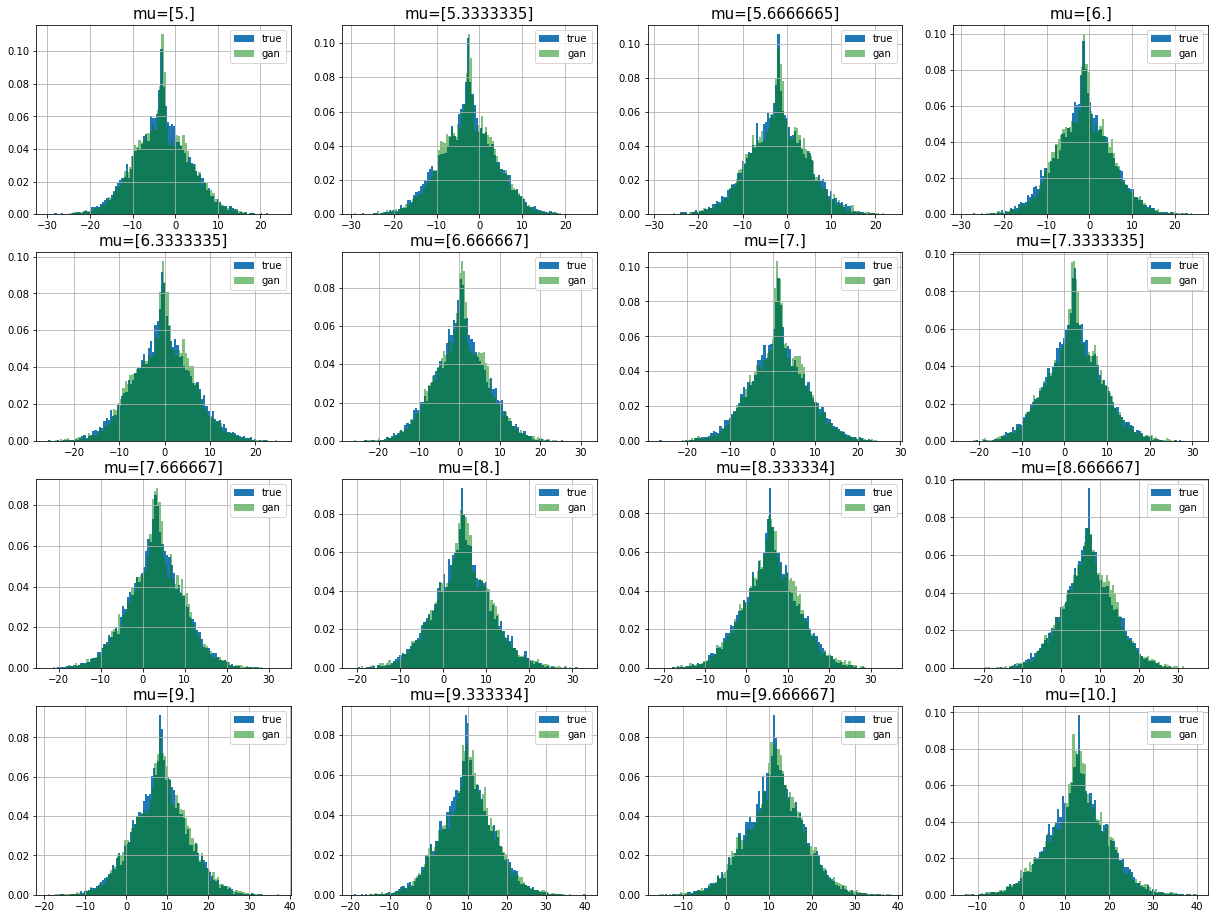

In [64]:
f = draw_mu_samples(mu)
plt.show()